# Clustering

## Unsupervised Learning
Das Ziel des maschinellen Lernens ist es, die Daten zu verstehen und versteckte Strukturen in den Daten zu erkennen. Das Besondere beim unüberwachten Lernen (unsupervised learning) ist, dass im Voraus kein Wissen über bekannte Ergebnisse vorhanden ist. Die am häufigsten verwendete Prozedur beim unüberwachten Lernen ist die Clusteranalyse.

## Clusteranalyse
Mit Hilfe der **Clusteranalyse** (Ballungsanalyse) werden Ähnlichkeitsstrukturen in größen Datensätzen erkannt. Anhand dieser Strukturen werden die Daten in disjunkte Gruppen (Cluster) eingeteilt. Die Gruppen werden so gebildet, dass die Daten innerhalb der Cluster ähnlich sind (**high inter-class similarity**) und sich von Daten aus anderen Clustern unterscheiden (**low intra-class similarity**). Es gibt verschiedene Algorithmen, um die Clusteranalyse durchzuführen. Jede Analyse hat Vor- und Nachteile und muss den Daten entsprechend ausgewählt werden, um eine hohe Qualität der Analyse zu erreichen. In diesem Notebook werden der k-Means-Algorithmus und die hierarchische Clusteranalyse beschrieben. 

Verschiedene Fragestellungen:
- Was wäre eine natürliche Gruppierung dieser Daten? Gibt es Ähnlichkeiten oder Abgrenzungen?
- Wie viele Cluster sind in den Daten erkennbar und machen Sinn?
- Welche Fälle können für einen bestimmten Zweck gleich behandelt werden?
- Wie kann man Distanzen zwischen Daten definieren?

Beispiel:
- Marketing: Hier können bspw. die Kunden anhand ihres Konsumverhaltens in Gruppen eingeteilt werden. Jedes Cluster bekommt die gleichen Kaufempfehlungen oder dieselbe Werbung zugeschickt. 
- Kundengruppen werden ebenfalls identifiziert, um passende Produkte zu designen


**Distanzen**

Die Ähnlichkeit von Daten wird mit dem Abstand zueinander gemessen. Die Abstandsmessung, die am weitesten verbreitet ist und in der Clusteranalyse am häufigsten zum tragen kommt ist die **Minkowski Distanz**.

$$d(a,b) = \big(\sum\limits_{i=1}^d |a_i-b_i|^p \big)^{1/p}$$

- **Euklidischer Abstand**: kürzester Abstand zweier Punkte (Gerade), p=2
- **Manhattan Distanz** (Cityblock Metrik): hier wird auf die Innenstadt Manhattans hingewiesen. Die Distanz zweier Punkte wird durch Aneinaderreihung von vertikalen und horizontalen Wegstücken berechnet, p=1



**Imports, die für dieses Notebook benötigt werden:**

In [1]:
import sklearn
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import scale
from sklearn import datasets

import numpy as np

import matplotlib.pyplot as plt
import scipy as sp
from scipy.cluster.hierarchy import dendrogram, linkage

import pandas as pd

### Bewertungskriterien

**Rand-Index**

Der Rand-Index (nach William M. Rand bennant) gibt Auskunft über die Ähnlichkeit der Daten im Cluster-Modell. Ein gutes Modell wird durch **Homogenität** (Precision) und **Vollständigkeit** (Recall) beschrieben. Der Rand-Index wird für beide Kriterien seperat berechnet.

Gegeben ist ein Dataset $S = \{o_1, \ldots, o_n\}$. Nachdem die Daten mittels eines Modells in Cluster eingeteilt wurden, werden die Label der Cluster mit der **Ground Truth** verglichen.  $X = \{X_1, \ldots, X_r\}$, die Partition von $S$ in $r$ subgruppen, $Y = \{Y_1, \ldots, Y_s\}$, die Partition von $S$ in $s$ Subgruppen:

+ a, die Anzahl der Paare von Elementen in S, die sich im selben Cluster in X und im selben Cluster in Y 
+ b, die Anzahl der Paare von Elementen in S, die sich in verschidenen Clustern in X und in verschiedenen Clustern in Y 
+ c, die Anzahl der Paare von Elementen in S, die sich im selben Cluster in X und in verschiedenen Clustern in Y 
+ d, die Anzahl der Paare von Elementen in S, die sich in verschiedenen Clustern in X und im selben Cluster in Y

befinden.

$ R = \frac{a+b}{a+b+c+d} = \frac{a+b}{{n \choose 2 }}$

Der Koeffizient liegt im Intervall [0;1]. Je näher der Wert bei 1 liegt, desto besser ist das Modell gemäß Homogenität bzw. Vollständigkeit.

Der Rand-Index ist in Python im Paket sklearn.metrics implementiert. Wir verwenden die Funktionen [metrics.homogeneity_score(labels_true, labels_pred)](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.homogeneity_score.html) für die Prüfung auf Homogenität und [metrics.completeness_score(labels_true, labels_pred)](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.completeness_score.html) für die Prüfung auf Vollständigkeit. 




In [2]:
metrics.homogeneity_score([1,2,3,4], [1,2,3,4])

1.0

In [3]:
metrics.homogeneity_score([1,2,0,0], [0,0,1,1])

0.66666666666666663

In [4]:
metrics.completeness_score([1,2,3,4], [1,2,3,4])

1.0

In [5]:
metrics.completeness_score([1,2,0,0], [1,1,0,0])

0.99999999999999989

Alle Daten werden demselben Cluster zugeordnet:

In [6]:
metrics.completeness_score([1,2,3,4], [0,0,0,0]) #Modell ist vollständig

1.0

In [7]:
metrics.homogeneity_score([1,2,3,4], [0,0,0,0]) # Aber nicht homogen zur ground Truth

0.0

**V-measure**

Um die Homogenität und Vollständigkeit mit nur einem Index bewerten zu können, wird folgende Formel angewandt:

    V = 2* (Precision * Recall) / (Precision + Recall)
    
In Python finden wir diese Funktion im selben Paket: wir verwenden für die Prüfung die Funktion [metrics.v_measure_score(labels_true, labels_pred)](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.v_measure_score.html)


In [8]:
metrics.v_measure_score([1,2,3,4], [0,0,0,0])

0.0

In [9]:
metrics.v_measure_score([1,2,3,4], [4,3,2,1])

1.0

In [10]:
metrics.v_measure_score([1,2,0,0], [0,0,1,1])

0.79999999999999993

## Clustering Methoden

### 1. k-Means-Algorithmus

Der k-Means-Algorithmus ist partitional: eine Clusterbildung erfolgt zunächst zufällig und wird nach und nach angepasst. Er eignet sich besonders gut bei großen Datensätzen. Voraussetzung für diese Methode ist, dass das Skalenniveau der Daten metrisch ist, da die Grundlage für die Methode die Distanzen zwischen Punkten darstellt. Außerdem wird angenommen, dass sich die Punkte in einem euklidischen Raum befinden. k-Means zielt auf Varianzenhomogenität zwischen den Clutestern ab. 


**Der Algorithmus**:
1. Die Anzahl k an Cluster werden festgelegt
2. Die Clusterzentren werden zufällig auf die Daten gelegt
3. Die Daten werden dem Clusterzentrum zugeteilt, das ihnen am nächsten liegt
4. Es wird der Mittelwert aus den Daten berechnet, die zu einem Cluster gehören. Dieser Mittelwert ist das neue Clusterzentrum
5. Nun wiederholen sich Schritt 3 und 4 so lange, bis kein Datenelement seine Cluster-Zugehörigkeit mehr wechselt und die Clusterzentren sich stabilisieren


Wie legt man k fest?
Da man auf den ersten Blick nicht sehen kann, wie viele Cluster sich in den Daten verstecken, ist es sinnvoll den Algorithmus mit verschiedenen Anzahl k auszuoprobieren. Für die richige Anzahl k ist der Mittelwert der Distanz aller Punkte der jeweiligen Cluster zum Clusterzentrum interessant zu betrachten: 
- Bei großen Distanzen einzelner Datenpunkte zum Clusterzentrum wird der Mittelwert der Distanzen hoch sein. In diesem Fall sollte man das Modell mit k+1 wiederholen
- Ab einem gewissen Punkt wird auffallen, dass die Mittelwerte stagnieren. Hier ist es nicht sinnvoll, die Anzahl der Cluster nicht weiter zu erhöhen


**Nun wird die Theorie an einem einfachen Beispiel demonstriert:**

Für eine simple Demonstration können wir Daten per Zufall generieren. Dabei wird die Funktion [numpy.random.randn()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.randn.html) verwendet, um ein zweidimensionales Array zu generieren.

In [11]:
n = 60 #Anzahl der Datensätze
x = np.random.randn(n,2)*5+15
x

array([[ 12.01761575,  17.353846  ],
       [ 10.86758128,   9.28251834],
       [  8.32510013,  10.83118815],
       [ 15.27566819,  25.00786603],
       [ 19.47661408,   4.73099359],
       [ 11.65215032,   7.22729708],
       [ 15.79754116,   2.82044984],
       [ 14.19908165,  20.0318536 ],
       [  9.80794176,  28.54785436],
       [ 12.84355698,  16.23536073],
       [ 13.85789586,  17.7662196 ],
       [ 26.24461708,  19.6628266 ],
       [  6.44101179,  18.36750421],
       [ 15.76655295,  17.52022531],
       [  9.59833683,  15.07386834],
       [ 16.33886757,  13.75171091],
       [ 16.04500359,  11.38815212],
       [ 21.26383269,  12.86735412],
       [  8.00331002,  17.63314368],
       [ 14.79545385,  17.2707959 ],
       [ 18.60457108,  21.00247429],
       [ 16.75603425,  13.16086107],
       [  5.96007771,  13.41705688],
       [ 21.72218972,  14.35794489],
       [ 18.34534804,  14.60158164],
       [ 10.84888991,  10.7650605 ],
       [ 19.32190652,  15.29993089],
 

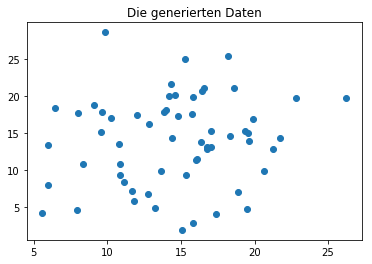

In [12]:
p = plt.scatter(x[:,0],x[:,1])
plt.title('Die generierten Daten')
plt.show()

Die Einstellungen für die k-Means Methode werden mit [sklearn.cluster.KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) vorgenommen. Hier wird dann auch die Anzahl an Clustern k übergeben. Mit fit() wird der Algorithmus schließlich an den Daten angewandt.

In [13]:
k = 3
kMeansCluster = KMeans(init='random', n_clusters=k)
kMeansCluster.fit(x)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Als Ausgabe bekommt man die Einstellungen zurück, die an den Daten angewandt wurden

In [14]:
kMeansCluster.labels_

array([2, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 0, 2, 2, 2, 0, 0, 0, 2, 2, 2, 0, 2,
       0, 0, 1, 0, 2, 2, 0, 0, 1, 2, 1, 0, 0, 0, 0, 2, 1, 1, 0, 2, 2, 2, 1,
       0, 1, 1, 1, 2, 2, 0, 1, 2, 1, 1, 0, 2, 1])

Jeder Datenpunkt hat ein Label erhalten.

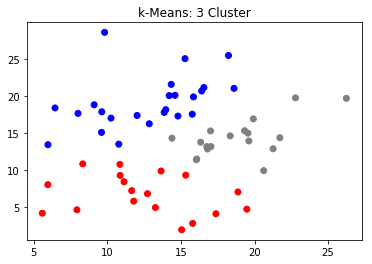

In [15]:
color_theme = np.array(['grey', 'red', 'blue'])

plt.scatter(x[:,0],x[:,1],color=color_theme[kMeansCluster.labels_])
plt.title('k-Means: 3 Cluster')

plt.show()

Ein spezielles Qualitätsmerkmal der k-Means Clusteranalyse ist die **Inertia**: Sie berechnet die Summer der Quadrate von Distanzen einzelner Datenpunkte zu den Clusterzentren innerhalb eines Clusters. Für eine hohe Datendichte spricht also ein möglichst kleiner Wert.

 Inertia=$\displaystyle\sum_{i=0}^{n}\min_{\mu_j \in C}(||x_i - \mu_j||^2)$


In [16]:
kMeansCluster.inertia_

1244.2831042630075

Falls man wissen möchte, wo die Zentren liegen, kann man sich diese wie folgt ausgeben (Zentren der Cluster, keine Datenpunkte an sich!):

In [17]:
kMeansCluster.cluster_centers_

array([[ 18.87990771,  14.30943925],
       [ 12.53343127,   6.7150114 ],
       [ 12.78537732,  19.13078926]])

Nun experimentieren wir ein bisschen mit den Clustern k.

In [18]:
k=4
kMeansCluster = KMeans(init='random', n_clusters=k)
kMeansCluster.fit(x)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [19]:
kMeansCluster.inertia_

931.81769102507417

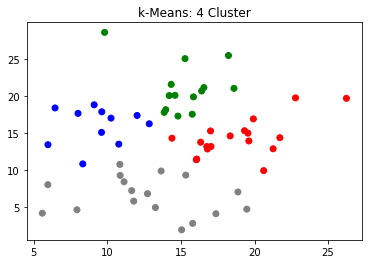

In [20]:
color_theme = np.array(['grey', 'red', 'blue', 'green'])

plt.scatter(x[:,0],x[:,1],color=color_theme[kMeansCluster.labels_])
plt.title('k-Means: 4 Cluster')

plt.show()

Wenn k größer wird, verringert sich der Wert der Inertia.

In [21]:
k=5
kMeansCluster = KMeans(init='random', n_clusters=k)
kMeansCluster.fit(x)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [22]:
kMeansCluster.inertia_

728.12216104887057

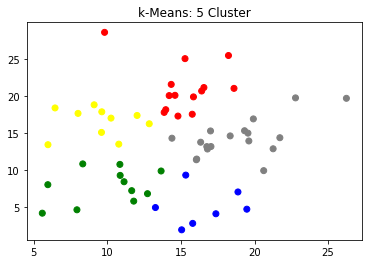

In [23]:
color_theme = np.array(['grey', 'red', 'blue', 'green', 'yellow'])

plt.scatter(x[:,0],x[:,1],color=color_theme[kMeansCluster.labels_])
plt.title('k-Means: 5 Cluster')

plt.show()

In [24]:
k=6
kMeansCluster = KMeans(init='random', n_clusters=k)
kMeansCluster.fit(x)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [25]:
kMeansCluster.inertia_

592.65285609234184

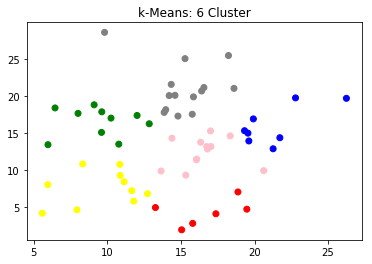

In [26]:
color_theme = np.array(['grey', 'red', 'blue', 'green', 'yellow', 'pink'])

plt.scatter(x[:,0],x[:,1],color=color_theme[kMeansCluster.labels_])
plt.title('k-Means: 6 Cluster')

plt.show()

In [27]:
k=7
kMeansCluster = KMeans(init='random', n_clusters=k)
kMeansCluster.fit(x)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300,
    n_clusters=7, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [28]:
kMeansCluster.inertia_

485.65908836642888

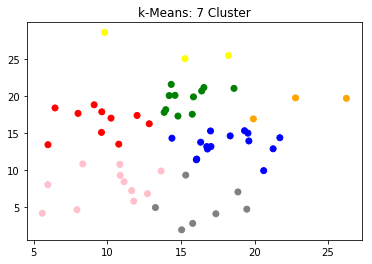

In [29]:
color_theme = np.array(['grey', 'red', 'blue', 'green', 'yellow', 'pink', 'orange'])

plt.scatter(x[:,0],x[:,1],color=color_theme[kMeansCluster.labels_])
plt.title('k-Means: 7 Cluster')

plt.show()

In [30]:
k=10
kMeansCluster = KMeans(init='random', n_clusters=k)
kMeansCluster.fit(x)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [31]:
kMeansCluster.inertia_

329.63217353096508

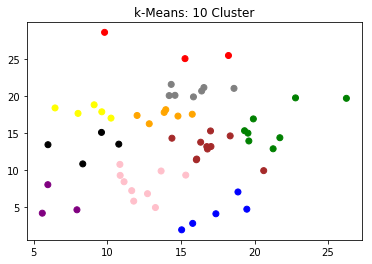

In [32]:
color_theme = np.array(['grey', 'red', 'blue', 'green', 'yellow', 'pink', 'orange', 'purple', 'brown', 'black'])

plt.scatter(x[:,0],x[:,1],color=color_theme[kMeansCluster.labels_])
plt.title('k-Means: 10 Cluster')

plt.show()

Je Je größer k, desto weniger verändert sich mit k+1 der Wert der Inertia. Bei beginnender Stagnation hat man aus Sicht des Algorithmus die optimale Anzahl an Clustern gefunden. Wenn man parallel die Grafiken betrachtet fällt auf, dass nun die Clustergröße nicht einheitlich ist. Es gibt Cluster, die aus sehr wenigen Datenpunkten bestehen. Außerdem gibt es keine scharfe Abgrenzung zwischen den Clustern.


Für die Bewertung des Modells benötigen wir als Vergleich die Ground Truth. Um hier den Rand-Index und v-Measure zu demonstrieren, wird ein neuer Datensatz mit Labels (y1) generiert.

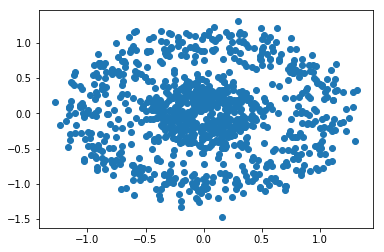

In [33]:
[X1, y1]  = datasets.make_circles(n_samples=1000, factor=.3, noise=.15)
plt.scatter(X1[:,0],X1[:,1])
plt.show()

In [34]:
kMeansCluster = KMeans(init='random', n_clusters=5)
kMeansCluster.fit(X1)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [35]:
metrics.homogeneity_score(y1,kMeansCluster.labels_)

0.66916781599917208

In [36]:
metrics.completeness_score(y1,kMeansCluster.labels_)

0.31248127840201373

In [37]:
metrics.v_measure_score(y1,kMeansCluster.labels_)

0.42602273215860098

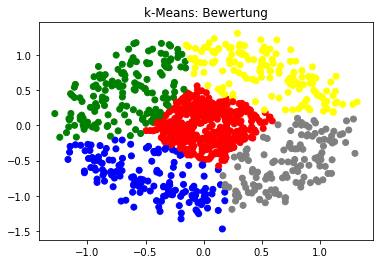

In [38]:
color_theme = np.array(['grey', 'red', 'blue', 'green', 'yellow'])

plt.scatter(X1[:,0],X1[:,1],color=color_theme[kMeansCluster.labels_])
plt.title('k-Means: Bewertung')
plt.show()

### 2. Hierarchische Clusteranalyse

Eine weitere Möglichkeit Daten in Cluster zu gruppieren ist die hierarchische Clusteranalyse. Diesem Verfahren liegen die Distanzen zwischen den Datenpunkten zugrunde. Schrittweise werden die Daten, die sich am nächsten liegen, miteinander verlinkt. Die Viualisierung und Dokumentation dieses Verfahrens erfolgt mittels eines Dendrogramms. 
Es gibt 2 Ansätze, wie man mit der hierarchischen Clusteranalyse zu einem Ergebnis gelangt: 

- Das **divisive** Clusterverfahren: Ausgangspunkt ist ein Cluster, das alle Daten enthält. Dieser Cluster wird in immer kleinere Cluster aufgeteilt, bis ein Cluster von einem Datenelement repräsentiert wird. 

- Das **agglomerative** Clusterverfahren: Ausgangspunkt sind n Cluster aus n Daten. Jedes Datum ist für sich ein Cluster. Schrittweise werden die 2 Daten/Cluster, die am nächsten zueinander liegen, zu einem Cluster zusammengefügt. Am Ende bestehen die Daten aus einem Cluster. 

**Mit welchen Kriterien werden die Daten verlinkt? Wie wird die Ähnlichkeit der Daten definiert?**

- **complete**: minimiert die maximale Distanz zwischen zwei Datenpunkten innerhalb eines Clusters
- **average**: minimiert den Mittelwert der Distanzen zwischen allen Daten eines Clusters
- **ward**: minimiert die Summe der Quadrate der Distanzen. (Gleiches Kriterium wie bei k-Means)
- **single**: betrachtet die Ähnlichkeit der zwei nächsten Datenpunkte (Sehr anfällig bei Ausreißern!)

Die Funktion für die Verlinkung erfolgt in Python mittels [scipy.cluster.hierarchy.linkage(y, method='single', metric='euclidean')](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.cluster.hierarchy.linkage.html). Um zu einem bestmöglichen Ergebnis zu gelangen, sollte das Modell mit allen Varianten durchgeführt und getestet werden.

**Wie viele Cluster machen Sinn?**

Nun ist es selbstverständlich nicht der Sinn des Verfahrens am Ende die Anzahl an Cluster, die auch an Daten vorhanden sind,  oder nur ein Cluster, das alle Daten enthält, als Ergebnis zu bekommen. An dieser Stelle ist das Dendrogramm hilfreich. es zeigt alle Ebenen der Analyse auf und gibt Spielraum bei der Wahl der Distanz, die zwischen den Clustern liegen soll. Trotzdem ist es hilfreich zu wissen, welche Anzahl an Clustern ein optimales Modell liefern.

1. Anzahl k wird vor der Analyse festgelegt. k würde sich ergeben, falls von Natur aus die Daten schon in k Klassen einzuteilen sind. Sind k Klassen erreicht, kann das Verfahren beendet werden
2. Wenn k nicht bekannt ist, ist die Kohäsion in den Clustern zu betrachten: Wenn ein weiterer Zusammenschluss von Clustern (agglomeratives Verfahren) zu einem geringen Zusammenhalt (z.B. geringe Datendichte, großer Radius) der Daten innerhalb des Clusters führt, kann man davon ausgehen, dass die optimale Anzahl k an Clustern erreicht ist.
3. Wenn für die Analyse eine maximale Distanz bekannt ist, die die Cluster untereinander haben sollen, kann man die Anzahl an Clustern mittels eines Dendrogramms ermitteln.

Als kleines Beispiel verwenden wir erneut die selbst generierten Daten x. Um die Verlinkung zu definieren, wird die Methode [scipy.cluster.hierarchy.linkage()](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.cluster.hierarchy.linkage.html) verwendet. Für die Clusteranalyse wird [sklearn.cluster.AgglomerativeClustering](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html) (das Verfahren wird agglomerativ durchgeführt) benötigt. Die Dokumentation für das Dendrogramm finden sie [hier](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

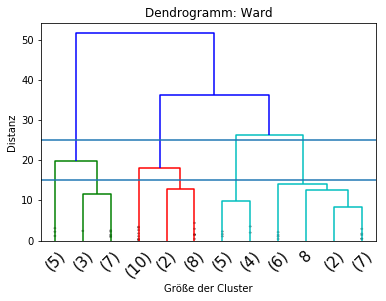

In [39]:
w = linkage(x, 'ward')
c = linkage(x, 'complete')
s = linkage(x, 'single')
a = linkage(x, 'average')
den =dendrogram(w, truncate_mode='lastp', p=12, leaf_rotation=45., leaf_font_size=15., show_contracted=True) 
plt.title('Dendrogramm: Ward')
plt.xlabel('Größe der Cluster')
plt.ylabel('Distanz')

plt.axhline(y=15)
plt.axhline(y=25)
plt.show()

**Zur Erklärung**: oben in der Wurzel befinden sich alle Daten in einem Cluster. Von oben nach unten werden die Daten immer weiter in kleinere Cluster eingeteilt. Auf der y-Achse sieht man die Distanzen, die die Punkte innerhalb der Cluster maximal zueinander haben. Möchte man nun also eine maximale Distanz von 25, kann man mit axhline() eine Linie in das Dendrogramm zeichnen und die Anzahl der Cluster ablesen. In diesem Fall hätten wir vier Cluster. Analog eine maximale Distanz von 15 zwischen den Punkten: fünf Cluster.
Außerdem kann anhand der horizontalen Abstände die Ähnlichkeit zwischen den Clustern abgelesen werden.
Auf der x-Achse kann abgelesen werden, wie viele Datenpunkte die Cluster enthalten.

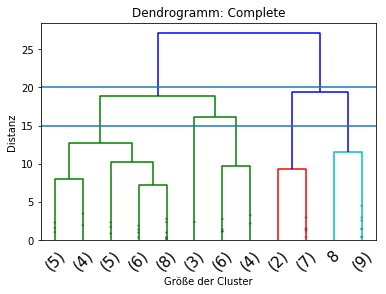

In [40]:
den =dendrogram(c, truncate_mode='lastp', p=12, leaf_rotation=45., leaf_font_size=15., show_contracted=True)
plt.title('Dendrogramm: Complete')
plt.xlabel('Größe der Cluster')
plt.ylabel('Distanz')

plt.axhline(y=15)
plt.axhline(y=20)
plt.show()

Im Vergleich zum 1. Dendrogramm haben wir nun bei anderer Verlinkung für die Distanz 20 zwei Cluster und für die Distanz 15 drei Cluster.

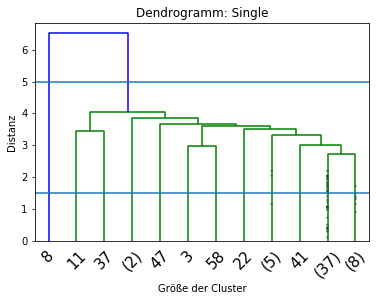

In [41]:
den =dendrogram(s, truncate_mode='lastp', p=12, leaf_rotation=45., leaf_font_size=15., show_contracted=True)
plt.title('Dendrogramm: Single')
plt.xlabel('Größe der Cluster')
plt.ylabel('Distanz')

plt.axhline(y=1.5)
plt.axhline(y=5)
plt.show()

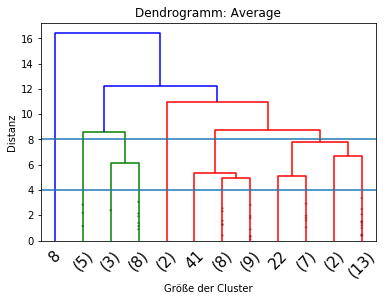

In [42]:
den =dendrogram(a, truncate_mode='lastp', p=12, leaf_rotation=45., leaf_font_size=15., show_contracted=True)
plt.title('Dendrogramm: Average')
plt.xlabel('Größe der Cluster')
plt.ylabel('Distanz')

plt.axhline(y=8)
plt.axhline(y=4)
plt.show()

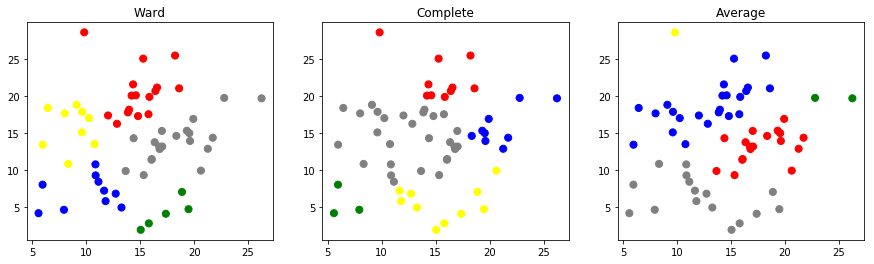

In [43]:
color_theme = np.array(['grey', 'red', 'blue', 'yellow', 'green'])

wardCluster = AgglomerativeClustering(linkage='ward',n_clusters =5)
wardCluster.fit(x)
plt.subplot(1,3,1)
plt.scatter(x[:,0],x[:,1],color=color_theme[wardCluster.labels_], s=50)
plt.title('Ward')




clustering = AgglomerativeClustering(linkage='complete',n_clusters =5)
clustering.fit(x)
plt.subplot(1,3,2)
plt.scatter(x[:,0],x[:,1],color=color_theme[clustering.labels_], s=50)
plt.title('Complete')





clustering = AgglomerativeClustering(linkage='average',n_clusters =5)
clustering.fit(x)
plt.subplot(1,3,3)
plt.scatter(x[:,0],x[:,1],color=color_theme[clustering.labels_], s=50)
plt.title('Average')
fig=plt.gcf()
fig.set_size_inches((15,4))

fig

Zum Schluss nochmals ein Vergleich zwischen den Verschiedenen Verlinkungen. Hierfür wird wieder der [X1, y1] Datensatz verwendet.

In [44]:
clusterWard = AgglomerativeClustering(linkage='ward',n_clusters =5)
clusterWard.fit(X1)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward',
            memory=Memory(cachedir=None), n_clusters=5,
            pooling_func=<function mean at 0x000000FC16ED78C8>)

In [45]:
metrics.v_measure_score(y1,clusterWard.labels_ )

0.60001177733694788

In [46]:
clusterComplete = AgglomerativeClustering(linkage='complete',n_clusters =5)
clusterComplete.fit(X1)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='complete',
            memory=Memory(cachedir=None), n_clusters=5,
            pooling_func=<function mean at 0x000000FC16ED78C8>)

In [47]:
metrics.v_measure_score(y1,clusterComplete.labels_ )

0.5044999609984242

In [48]:
clusterAverage = AgglomerativeClustering(linkage='average',n_clusters =5)
clusterAverage.fit(X1)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='average',
            memory=Memory(cachedir=None), n_clusters=5,
            pooling_func=<function mean at 0x000000FC16ED78C8>)

In [49]:
metrics.v_measure_score(y1,clusterAverage.labels_ )

0.57703616324124474

## Vergleich zwischen hierarchischer Clusteranalyse und dem k-Means Algorithmus

In [50]:
np.random.seed(0)

n = 1500
dataRaw = np.random.rand(n, 2)


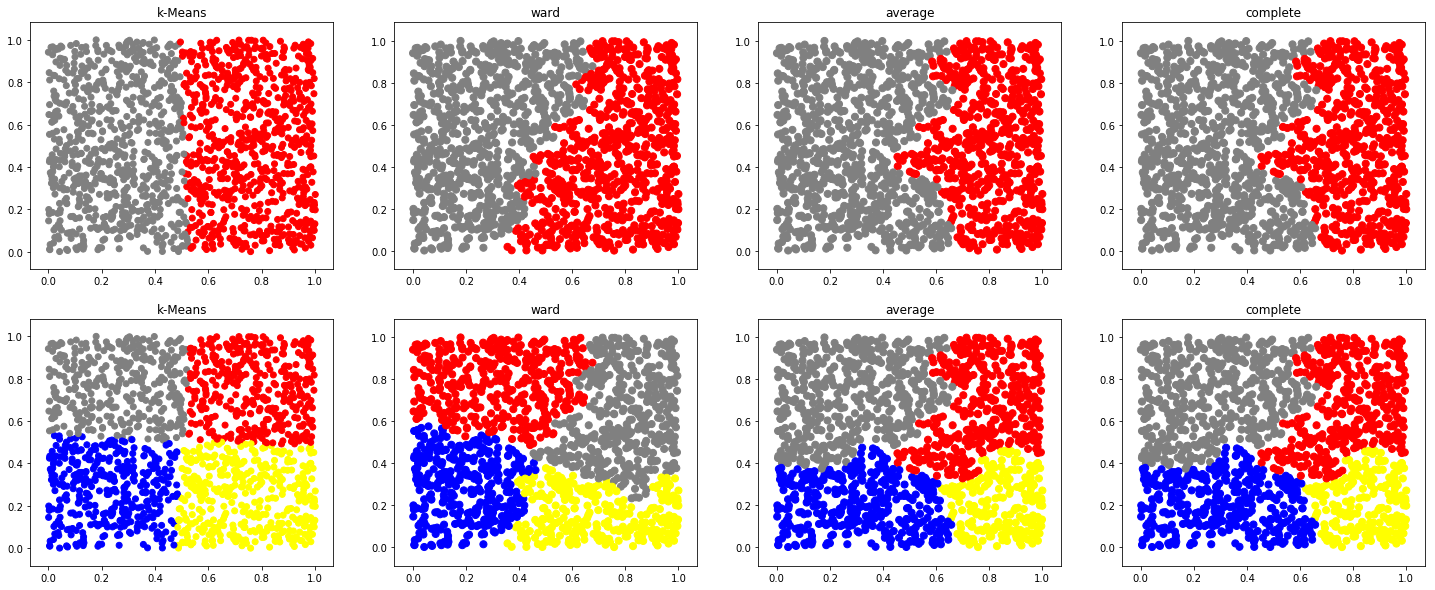

In [51]:
k=2

kMeans2 = KMeans(init='random', n_clusters=k)
kMeans2.fit(dataRaw)
plt.subplot(2,4,1)
plt.scatter(dataRaw[:,0],dataRaw[:,1],color=color_theme[kMeans2.labels_])
plt.title('k-Means')


ward = AgglomerativeClustering(linkage='ward',n_clusters =k)
ward.fit(dataRaw)
plt.subplot(2,4,2)
plt.scatter(dataRaw[:,0],dataRaw[:,1],color=color_theme[ward.fit_predict(dataRaw)], s=50)
plt.title('ward')
 

average = AgglomerativeClustering(linkage='average',n_clusters =k)
average.fit(dataRaw)
plt.subplot(2,4,3)
plt.scatter(dataRaw[:,0],dataRaw[:,1],color=color_theme[average.fit_predict(dataRaw)], s=50)
plt.title('average')


complete = AgglomerativeClustering(linkage='average',n_clusters =k)
complete.fit(dataRaw)
plt.subplot(2,4,4)
plt.scatter(dataRaw[:,0],dataRaw[:,1],color=color_theme[complete.fit_predict(dataRaw)], s=50)
plt.title('complete')


k=4
kMeans4 = KMeans(init='random', n_clusters=k)
kMeans4.fit(dataRaw)
plt.subplot(2,4,5)
plt.scatter(dataRaw[:,0],dataRaw[:,1],color=color_theme[kMeans4.labels_])
plt.title('k-Means')



ward = AgglomerativeClustering(linkage='ward',n_clusters =k)
ward.fit(dataRaw)
plt.subplot(2,4,6)
plt.scatter(dataRaw[:,0],dataRaw[:,1],color=color_theme[ward.fit_predict(dataRaw)], s=50)
plt.title('ward')

average = AgglomerativeClustering(linkage='average',n_clusters =k)
average.fit(dataRaw)
plt.subplot(2,4,7)
plt.scatter(dataRaw[:,0],dataRaw[:,1],color=color_theme[average.fit_predict(dataRaw)], s=50)
plt.title('average')


complete = AgglomerativeClustering(linkage='average',n_clusters =k)
complete.fit(dataRaw)
plt.subplot(2,4,8)
plt.scatter(dataRaw[:,0],dataRaw[:,1],color=color_theme[complete.fit_predict(dataRaw)], s=50)
plt.title('complete')




compare=plt.gcf()
compare.set_size_inches((25,10))
compare

## Fazit

In diesem Notebook wurde die Clusteranalyse in der Theorie vorgestellt und an zufällig generierten Daten getestet. Dabei wurde der Fokus auf den k-Means Algorithmus und die Hierarchische Clusteranalyse gelegt. Da es sich bei der Clusteranalyse um ein Verfahren des unüberwachten Lernens handelt, ist die Qualität des Modells nicht nur vom richtigen Algorithmus oder der Ground Truth abhängig, sondern vor allem von der Erfahrung und Subjektivität des Data Scientist: Dieser entscheidet über die optimale Anzahl an Clustern, die für eine hohe Trennschärfe zwischen den Clustern und einer hohen Dichte innerhalb der Cluster entscheiden sind. 

<small><i> Dieses Notebook wurde im Rahmen des Wahlfachs 'Data Science mit Python und R' von Denise Strehler am 07.12.2017 erstellt. Das Review erfolgte am ... durch Jasmin Ruck.</i></small>